In [97]:
#IMPORTS

from google.colab import files
import matplotlib.pyplot as plt
import math
import numpy as np
from PIL import Image as im
import cv2 as cv
import random
import tensorflow as tf
from tensorflow import keras

In [2]:
#Uploading Bismuth Profiles

uploaded = files.upload()

Saving Bi_mp-23152_computed Profile_0.7.txt to Bi_mp-23152_computed Profile_0.7.txt
Saving Bi_mp-23152_computed Profile_0.0.txt to Bi_mp-23152_computed Profile_0.0.txt
Saving Bi_mp-23152_computed Profile_0.1.txt to Bi_mp-23152_computed Profile_0.1.txt
Saving Bi_mp-23152_computed Profile_0.2.txt to Bi_mp-23152_computed Profile_0.2.txt
Saving Bi_mp-23152_computed Profile_0.3.txt to Bi_mp-23152_computed Profile_0.3.txt
Saving Bi_mp-23152_computed Profile_0.4.txt to Bi_mp-23152_computed Profile_0.4.txt
Saving Bi_mp-23152_computed Profile_0.5.txt to Bi_mp-23152_computed Profile_0.5.txt
Saving Bi_mp-23152_computed Profile_0.6.txt to Bi_mp-23152_computed Profile_0.6.txt
Saving Bi_mp-23152_computed Profile_0.8.txt to Bi_mp-23152_computed Profile_0.8.txt
Saving Bi_mp-23152_computed Profile_0.9.txt to Bi_mp-23152_computed Profile_0.9.txt
Saving Bi_mp-23152_computed Profile_1.0.txt to Bi_mp-23152_computed Profile_1.0.txt


In [3]:
#Creating an array of file names for all Bi files 

files_to_open = []
file_name_ending = "Bi_mp-23152_computed Profile_"
for val in range(0,11,1):
  #print(val/10)
  file_name = file_name_ending + str(val/10) + ".txt" 
  files_to_open.append(file_name)

In [4]:
#Defining Parameters for Image Conversion
scale = 5 #Scales the radii of the diffraction profiles (large scale increases space between 'rings')
resolution = 126 #Determines image resolution

In [5]:
#Generating one hot vectors for labels
one_hot_vecs = []
for i in range(0,len(files_to_open)):
  one_hot_vec =[0] * len(files_to_open)
  one_hot_vec[i] = 1
  one_hot_vecs.append(one_hot_vec)

11


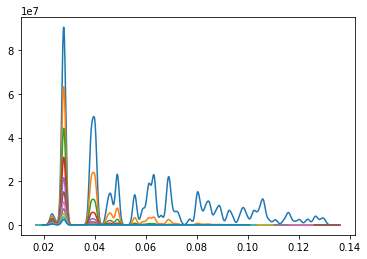

In [6]:
#Opening files and processing data into lists of radii and intensities 

radii = [] 
intenisties = []

for file_name in files_to_open:
  file = open(file_name, "r")
  array_vals = []
  for line in file:
    data_point = line.split() #X and Y values are separated by a space

    array_vals.append([scale*math.tan(math.radians(float(data_point[0]))/2),float(data_point[1])]) #converts angles into radii  
  
  radius,intensity = zip(*array_vals) #Unzipping array of [x_values,y_values] into list of x_values and y_values
    
  radii.append(radius)
  intenisties.append(intensity)
    
for i in range(0,len(radii)):
  plt.plot(radii[i],intenisties[i])


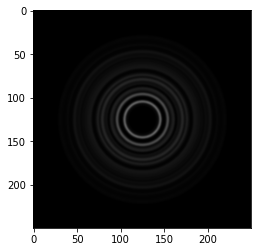

[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [108]:
#Converting Radii-Intensity data into Diffraction Patterns

#This code generates a two-part circular mask 
#This mask obscures all points greater than a distance of 'curr_rad' and less than a distance of 'prev_rad'
#This creates a circle, the radius of which depends on the resolution of the angle data
#This mask is applied to a white image in order to generate a fully white circle 
#source: https://stackoverflow.com/questions/44865023/how-can-i-create-a-circular-mask-for-a-numpy-array

#Adding an invert option because it looks cool
invert = False

images = [] #images will be a list of [diffraction patterns, labels]

#Setting up a (resolution,resolution) sized array for the mask
#Ogrid is used to setup a row and column vector of values ranging from 0 to resolution

X, Y = np.ogrid[:resolution,:resolution]
centre_val = resolution/2

#The values stored in each vector are squared and the vectors are added (using broadcasting)
#The value at each point of the resulting array is the 'distance' between that point and the centre
dist_from_center = np.sqrt((X-centre_val)**2+(Y-centre_val)**2)

#white image used to generate white circles
#array_ones = np.ones((resolution,resolution))

for i in range(0,len(radii)): #iterates through all diffraction profiles
  
  #creates a 'base image' for the background of the image
  if invert:
    base_img = np.ones((resolution,resolution))*256
  else:
    base_img = np.zeros((resolution,resolution))
  
  radius = radii[i]
  intensity = intenisties[i]
  
  #Scaling the radii of each diffraction pattern
  #This ensures that the smallest radii rings (the brightest rings) in all images are of a uniform size (5% of the total resolution)
  min_rad = radius[0]
  radius_adjustment_value = (resolution/2)*0.1/min_rad

  prev_rad = radius[0]*radius_adjustment_value
  max_intensity = max(intensity)
  for j in range(0,len(radius)):   
    
    curr_rad = radius[j]*radius_adjustment_value
    
    #Defining the two-part mask
    mask = (dist_from_center <= curr_rad) & (dist_from_center > prev_rad)
    
    unscaled_circle = np.ones((resolution,resolution)) #np.copy(array_ones)
    
    #applies mask to white image
    unscaled_circle[~mask]=0
    
    #adds/subtracts the new circle to the base image depending on inversion
    if invert:
      base_img -= unscaled_circle*intensity[j]*200/max_intensity #intensity values are scaled by the max intensity
    else:
      base_img += unscaled_circle*intensity[j]*200/max_intensity
    prev_rad = curr_rad

  #Blurring and randomly translating images to generate more datapoints
  blurry_img = cv.GaussianBlur(base_img,(5,5),0)
  
  for q in range(0,15):
    M = np.float32([
    [1, 0, random.randint(-3,3)],
    [0, 1, random.randint(-3,3)]
    ])
    new_image = cv.warpAffine(blurry_img, M, (resolution,resolution))
    
    images.append([new_image,one_hot_vecs[i]])

"""
for base_img in images:
    plt.imshow(im.fromarray(base_img[0]))
    print(base_img[1])
    plt.show()
"""
plt.imshow(im.fromarray(images[0][0]))
plt.show()
print(images[0][1])
#Shuffles dataset
random.shuffle(images)

In [68]:
#Extracting and reshaping arrays of X and Y values from dataset

X,Y = zip(*images)

X_array = np.array(X).reshape(-1,int(resolution),int(resolution),1)
Y_array = np.array(Y).reshape(-1,11)

#Array shape is checked to ensure they are of equal length and of correct size
print(X_array.shape)
print(Y_array.shape)

(165, 125, 125, 1)
(165, 11)


In [101]:
#Defining neural nets

def build_basic_model():
  model = keras.models.Sequential([
      keras.layers.Conv2D(filters=20, kernel_size=(8,8), strides=(2,2), activation='relu', input_shape=(resolution,resolution,1)),
      #keras.layers.BatchNormalization(),
      keras.layers.MaxPool2D(pool_size=(2,2), strides=(1,1)),
      keras.layers.Conv2D(filters=40, kernel_size=(8,8), strides=(2,2), activation='relu'),
      #keras.layers.BatchNormalization(),
      keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
      keras.layers.Flatten(),
      keras.layers.Dense(50, activation='relu'),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(11, activation='softmax')
  ])
  return model

def build_cnn_model():
  cnn_model = keras.Sequential([
      keras.layers.Conv2D(filters=18,kernel_size=(5,5),activation=tf.nn.relu),           
      keras.layers.MaxPool2D(pool_size=(2, 2)),
      keras.layers.Conv2D(filters=36,kernel_size=(5,5),activation=tf.nn.relu), 
      keras.layers.MaxPool2D(pool_size=(2, 2)),
      keras.layers.Flatten(),
      keras.layers.Dense(128, activation=tf.nn.relu),
      keras.layers.Dropout(0.6),
      keras.layers.Dense(11, activation=tf.nn.softmax)
  ])
    
  return cnn_model

In [102]:
#Building and compiling CNN

model = build_cnn_model()

#Defining a decaying learning rate
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=0.05,
  decay_steps=10000,
  decay_rate=0.95)

opt = keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

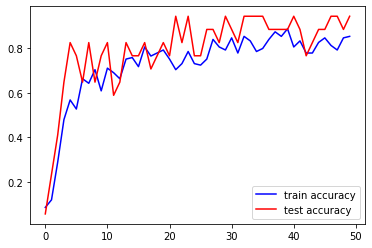

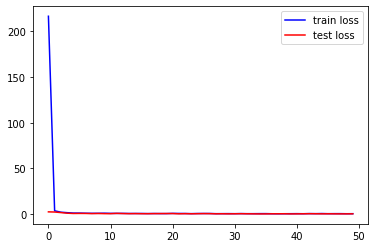

In [103]:
#Defining lists to store accuracy and loss values over the course of training 
accuracy_values = []
validation_accuracy_values= []
loss_values = []
validation_loss_values = []

EPOCHS = 50

#Training Neural Net
for i in range(0,EPOCHS):
  
  history = model.fit(X_array,Y_array,batch_size=30,epochs=1,validation_split=0.1,verbose=0)

  #Storing accuracy and loss values
  accuracy_values.append(history.history['accuracy'][0])
  validation_accuracy_values.append(history.history['val_accuracy'][0])
  loss_values.append(history.history['loss'][0])
  validation_loss_values.append(history.history['val_loss'][0])

#Plotting NN performance
f1 = plt.figure()
f2 = plt.figure()
ax1 = f1.add_subplot(111)

ax1.plot(accuracy_values, "-b",label = "train accuracy")
ax1.plot(validation_accuracy_values, "-r",label = "test accuracy")
ax1.legend()
ax2 = f2.add_subplot(111)
ax2.plot(loss_values, "-b",label = "train loss")
ax2.plot(validation_loss_values, "-r",label = "test loss")
ax2.legend()